<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device agnostic code

In [42]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [43]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [44]:
!nvidia-smi

Thu Nov  9 17:52:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

A good practice is to start small ( get a subset of the dataset ) and then upscale to the full dataset.

The dataset is a subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per classe (750 training, 250 testing).

Our dataset starts with 3 classes of foof and only 10% of the images ( ~75 training, 25 testing).


In [45]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


In [46]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data prep and data exploration)

In [47]:
import os
def walk_trhough_dir(dir_path):
  """Walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [48]:
walk_trhough_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [49]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path / "test"

In [50]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Visualizing and image

Let's write some code to:

1. Get all of the image paths
2. Piack a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL

Random image path: data/pizza_steak_sushi/test/sushi/343036.jpg
Image class: sushi
Image height: 512
Image width: 384
Image shape: (512, 384, 3)


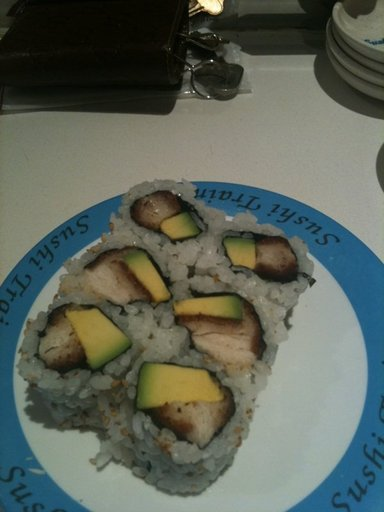

In [53]:
import random
import numpy as np
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (aka the name of the directory) (.parent gives the full path and .stem the last dir)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
image_as_array = np.asarray(img)
print(f"Image shape: {image_as_array.shape}")


img

## 3. Transforming data

Before using the image data with PyTorch:

1. Turn the target data into tensors (in our case, numerical representation of the images)

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`.

We'll call these `Dataset` and `DataLoader` respectively.

In [54]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 Transforming data with `torchvision.transforms`

In [58]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [61]:
data_transform(img)

tensor([[[0.1765, 0.1529, 0.0863,  ..., 0.1765, 0.2745, 0.4275],
         [0.1686, 0.1098, 0.0627,  ..., 0.2549, 0.3922, 0.4588],
         [0.1569, 0.1216, 0.0745,  ..., 0.4314, 0.4627, 0.4745],
         ...,
         [0.1333, 0.1176, 0.1020,  ..., 0.1451, 0.1490, 0.1529],
         [0.1255, 0.1255, 0.1137,  ..., 0.1529, 0.1608, 0.1686],
         [0.1333, 0.1176, 0.1294,  ..., 0.1647, 0.1725, 0.1765]],

        [[0.1843, 0.1608, 0.0941,  ..., 0.1804, 0.2784, 0.4353],
         [0.1843, 0.1137, 0.0588,  ..., 0.2588, 0.4000, 0.4667],
         [0.1647, 0.1255, 0.0745,  ..., 0.4392, 0.4745, 0.4902],
         ...,
         [0.3216, 0.3020, 0.2431,  ..., 0.3647, 0.4000, 0.4118],
         [0.3059, 0.3137, 0.2784,  ..., 0.3961, 0.4118, 0.4235],
         [0.2784, 0.3059, 0.3216,  ..., 0.4039, 0.4235, 0.4353]],

        [[0.1412, 0.1176, 0.0588,  ..., 0.1216, 0.2078, 0.3451],
         [0.1294, 0.0706, 0.0314,  ..., 0.2039, 0.3255, 0.3765],
         [0.1059, 0.0784, 0.0392,  ..., 0.3647, 0.3961, 0.